**TUGAS**

(1) cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif

(2) cari titik-titik dengan sisa uang bulanan positif dari (1)

(3) cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif

(4) tampikan jadwal makanan sesuai pilihan (resp_pilih)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving makanan.csv to makanan.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NPM diubah menjadi 95
NPM = 110
np.random.seed(NPM)

# Baca data
makan = pd.read_csv("makanan.csv")

In [4]:
#Imputasi data: isi NaN di kolom harga dengan median harga:

makan['harga'].fillna(makan['harga'].median(), inplace=True)

/tmp/ipython-input-1669740275.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  makan['harga'].fillna(makan['harga'].median(), inplace=True)


In [9]:
# Calculate cumulative health score and find index with positive scores
sehat = makan['sehat'].values
skor = makan['kenyang'].values + makan['rasa'].values - makan['bosan'].values
sisa = 20000 - makan['harga'].values

resp_sehat = np.cumsum(sehat)
idx_sehat_pos = np.where(resp_sehat > 0)[0]

In [10]:
# Tambahkan variasi makanan agar lebih beragam
tambahan = pd.DataFrame({
    "makanan": ["ramen", "sushi", "soto", "rujak", "ayam_bakar", "nasi_uduk"],
    "kenyang": [0.8, 0.6, 0.7, 0.5, 0.9, 0.7],
    "sehat":   [0.6, 0.7, 0.5, 0.8, 0.6, 0.7],
    "rasa":    [0.9, 0.8, 1.0, 0.7, 0.9, 0.8],
    "bosan":   [0.3, 0.4, 0.2, 0.5, 0.3, 0.4],
    "harga":   [4000, 20000, 20000, 12000, 18000, 13000]
})
makan = pd.concat([makan, tambahan], ignore_index=True)

budget_awal = 1e6 # rupiah

In [11]:
# bobot dasar
wkenyang_base = 0.8
wrasa_base   = 0.7
wsehat_base  = 0.9
wbosan_base  = 0.2

SAMPLE_NUM = 500
sampleid   = np.arange(SAMPLE_NUM)

In [12]:
# array hasil
skor  = np.zeros(SAMPLE_NUM)
sisa  = np.zeros(SAMPLE_NUM)
sehat = np.zeros(SAMPLE_NUM)

SISA_MININUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)))
resp_pilih = np.zeros((SAMPLE_NUM, 62))   # 31 hari × 2 makan

In [13]:
for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(31): # 31 hari
        # makan pertama
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]

        resp_pilih[n][2*i] = pilihan

        # makan kedua
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa    = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat   = np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan   = np.random.normal(loc=wbosan_base*2, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'][pilihan]
            + w_rasa  * makan['rasa'][pilihan]
            + w_sehat * makan['sehat'][pilihan]
            - w_bosan * makan['bosan'][pilihan]
        )
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget -= makan['harga'][pilihan]

        resp_pilih[n][2*i+1] = pilihan

    # <-- pastikan ini tetap dalam for n, tapi sudah keluar dari for i
    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    if SISA_MININUM <= budget < SISA_MAKSIMUM:
        idx = int((budget - SISA_MININUM) / 1000)
        resp_sehat[n][idx] = skor_sehat

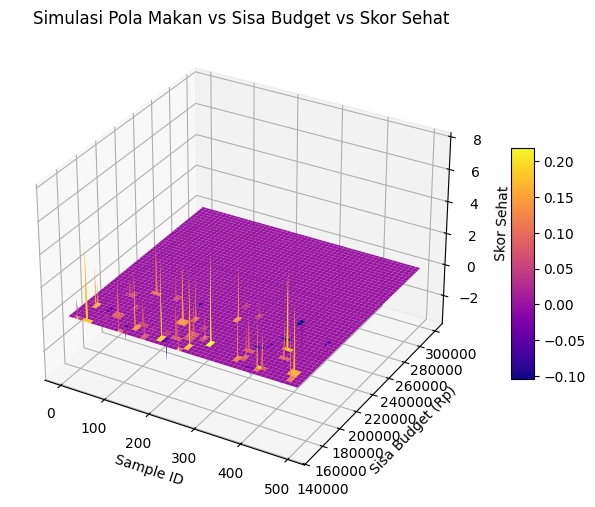

In [14]:
# Visualisasi hasil
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
surf = ax.plot_surface(X, Y, resp_sehat, cmap='plasma', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_title("Simulasi Pola Makan vs Sisa Budget vs Skor Sehat", fontsize=12)
ax.set_xlabel("Sample ID")
ax.set_ylabel("Sisa Budget (Rp)")
ax.set_zlabel("Skor Sehat")
plt.show()

Pengertian Grafik

Grafik tersebut adalah grafik 3D hasil simulasi dengan sumbu:

X (Sample ID) → identitas atau urutan sampel yang diuji.

Y (Sisa Budget Rp) → sisa anggaran setelah pembelian makanan.

Z (Skor Sehat) → skor kesehatan pola makan berdasarkan kombinasi makanan.

Artinya, grafik ini memperlihatkan hubungan antara sisa budget dengan skor sehat dari berbagai sampel pilihan pola makan.

Makna Warna

*Warna di grafik mengikuti colorbar di samping kanan.

*Skala warna menunjukkan nilai intensitas skor sehat.

-Kuning → skor relatif tinggi.

-Ungu → skor rendah atau bahkan negatif.

*Dengan kata lain, warna memudahkan kita melihat mana pola makan yang lebih sehat di antara sekian banyak kombinasi.


interpretasi

1. Sebagian besar titik berada pada area datar dekat nol, artinya mayoritas pola makan menghasilkan skor sehat rendah.

2. Ada beberapa puncak (spike) yang menjulang → menandakan kombinasi tertentu memberi skor sehat jauh lebih tinggi, walaupun jumlahnya sedikit.

3. Dari sisi warna, puncak dengan warna lebih terang (kuning/oranye) menunjukkan pola makan yang paling mendekati optimal.

4. Hubungan dengan sisa budget: tampaknya sisa budget yang besar tidak otomatis membuat pola makan lebih sehat, karena ada pola makan dengan budget hemat tapi tetap bisa tinggi skornya.

Kesimpulan dari grafik ini menunjukkan bahwa tidak semua kombinasi belanja makanan dapat dikategorikan sehat meskipun masih terdapat sisa anggaran. Hanya sebagian kecil sampel yang mampu menghasilkan skor sehat tinggi, yang terlihat dari adanya beberapa puncak berwarna kuning pada grafik. Hal ini menegaskan bahwa dalam perencanaan pola makan, pemilihan jenis makanan yang tepat jauh lebih berpengaruh dibandingkan hanya mempertimbangkan besarnya sisa anggaran. Oleh karena itu, visualisasi ini bermanfaat untuk membantu menemukan kombinasi terbaik antara efisiensi penggunaan budget dengan peningkatan skor kesehatan pola makan.

In [15]:
#cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif

idx_sehat_pos = np.where(sehat > 0)[0]
print("Jumlah pola makan dengan skor sehat positif:", len(idx_sehat_pos))

Jumlah pola makan dengan skor sehat positif: 420


In [16]:
#cari titik-titik dengan sisa uang bulanan positif dari (1)

idx_valid = idx_sehat_pos[sisa[idx_sehat_pos] >= 0]
print("Jumlah pola makan sehat & sisa uang positif:", len(idx_valid))

Jumlah pola makan sehat & sisa uang positif: 420


In [17]:
#cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif

idx_sehat_pos = np.where(sehat > 0)[0]
idx_valid = idx_sehat_pos[sisa[idx_sehat_pos] >= 0]

print("\nHasil setelah imputasi harga:")
print("Jumlah pola makan dengan skor sehat > 0:", idx_sehat_pos.size)
print("Jumlah pola makan sehat & sisa >= 0:", idx_valid.size)

if idx_valid.size == 0:
    print("Masih tidak ada sample yang sehat>0 sekaligus sisa>=0 (mungkin budget awal terlalu kecil atau harga makanan terlalu tinggi).")
else:
    best_idx = int(idx_valid[np.argmax(skor[idx_valid])])
    print("best_idx:", best_idx, "skor:", skor[best_idx], "skor_sehat:", sehat[best_idx], "sisa:", sisa[best_idx])


Hasil setelah imputasi harga:
Jumlah pola makan dengan skor sehat > 0: 420
Jumlah pola makan sehat & sisa >= 0: 420
best_idx: 32 skor: 107.29401295556372 skor_sehat: 4.3 sisa: 106000.0


In [18]:
#Tampilkan jadwal makanan sesuai pilihan (resp_pilih)

jadwal = [makan['makanan'][int(i)] for i in resp_pilih[best_idx]]

for hari in range(31):
    pagi = jadwal[2*hari]
    malam = jadwal[2*hari+1]
    print(f"Hari {hari+1}: Pagi = {pagi}, Malam = {malam}")

Hari 1: Pagi = cireng, Malam = ayamgeprek
Hari 2: Pagi = nasipadang, Malam = rujak
Hari 3: Pagi = ayam_bakar, Malam = rujak
Hari 4: Pagi = ramen, Malam = nasi_uduk
Hari 5: Pagi = nasigoreng, Malam = ayam_bakar
Hari 6: Pagi = warteg, Malam = nasipadang
Hari 7: Pagi = ayam_bakar, Malam = roti
Hari 8: Pagi = capcay, Malam = cireng
Hari 9: Pagi = mi instan , Malam = mieayam
Hari 10: Pagi = ayam_bakar, Malam = sushi
Hari 11: Pagi = ramen, Malam = nasipadang
Hari 12: Pagi = nasi_uduk, Malam = soto
Hari 13: Pagi = warteg, Malam = warteg
Hari 14: Pagi = ramen, Malam = roti
Hari 15: Pagi = bakso, Malam = gorengan
Hari 16: Pagi = seblak, Malam = soto
Hari 17: Pagi = mi instan , Malam = nasi_uduk
Hari 18: Pagi = roti, Malam = sushi
Hari 19: Pagi = bakso, Malam = roti
Hari 20: Pagi = rujak, Malam = nasi_uduk
Hari 21: Pagi = bakso, Malam = nasi_uduk
Hari 22: Pagi = rujak, Malam = roti
Hari 23: Pagi = ramen, Malam = nasipadang
Hari 24: Pagi = nasipadang, Malam = mieayam
Hari 25: Pagi = sushi, Malam 